# Testing stock

* 時間, `最近成交價`, `當盤成交量`, `累積成交量`, `最佳五檔（賣價）`, `最佳五檔（賣量）`, `最佳五檔（買價）`, `最佳五檔（買量）`

In [1]:
import re
import numpy as np

dataset_path = "./dataset/Taiwan_5s/"
choose = 500

def getDataset(path):
    dataset = []
    with open(path, 'r') as fp:
        for i in range(500):
            data = fp.readline()
            if len(data) == 0:
                break
            data = data.replace('-', '0')
            data = re.split(',|\n', data)[1:-1]
            data[3] = data[3].split('_')[0]
            data[4] = data[4].split('_')[0]
            data[5] = data[5].split('_')[0]
            data[6] = data[6].split('_')[0]
            try:
                dataset.append(np.asarray(data, dtype=np.float))
            except ValueError:
                print(data)
                
    return np.asarray(dataset)

# My own MinMaxScaler

In [2]:
class MinMaxScaler:
    __min = 0.
    __max = 1.
    __range = 1.
    __feature_range = (0, 1)
    __scale = 1.
    def __init__(self):
        pass
    def getScalerData(self, dataset, offset=0.1, feature_range=(0, 1)):
        data_max = np.max(dataset)
        data_min = np.min(dataset)
        if len(dataset) == 1:
            range_temp = dataset * offset
        else:
            range_temp = (data_max - data_min) * (1 + offset)
        self.__min = data_max - range_temp
        self.__max = data_min + range_temp
        self.__range = self.__max - self.__min
        self.__feature_range = feature_range
        self.__scale = (feature_range[1] - feature_range[0]) / self.__range
        return self.getTransformData(dataset)
    def getTransformData(self, dataset):
        return (dataset - self.__min) * self.__scale + self.__feature_range[0]
    def getInverseData(self, scalerDataset):
        return (scalerDataset - self.__feature_range[0]) / self.__scale + self.__min
    def getParameter(self):
        return self.__min, self.__max, self.__range, self.__feature_range, self.__scale
    def updatePatameter(self, parameter):
        self.__min, self.__max, self.__range, self.__feature_range, self.__scale = parameter

# create dataset
* 1. price use MinMaxScaler with offset 0.1
* 2. trading volume using local MinMaxScaler
* 3. best 1 sell price use MinMaxScaler in 1.
* 4. best 1 buy price use MinMaxScaler in 1.
* 5. if sell count > buy count than > 0.5

In [3]:
from tensorflow.keras.utils import to_categorical

def create_dataset(path, input_days=60, output_days=1):
    dataset = getDataset(path)
    price_sc = MinMaxScaler()
    price_sc.getScalerData(np.array([dataset[0][0]]), offset=0.1, feature_range=(0, 1))
    dataset[:, [0, 3, 5]] = price_sc.getTransformData(dataset[:, [0, 3, 5]])
    output = []
    label = []
    for i in range(input_days, choose - output_days + 1):
        temp = dataset[i-input_days:i]
        # create total set
        temp_sc = MinMaxScaler()
        a = dataset[i-input_days:i, [0, 3, 5]]
        out_temp = dataset[i:i+output_days, 0]
        out_max = np.max(out_temp)
        out_min = np.min(out_temp)
        out_mean = (out_max + out_min) / 2
        in_data = a[-1, 0]
        if in_data < out_mean:
            y = 2
        elif in_data > out_mean:
            y = 0
        else :
            y = 1
        b = temp_sc.getScalerData(temp[:, 1:2])
        sell_count = temp[:, 4:5]
        buy_count = temp[:, 6:7]
        temp_scale = np.absolute(sell_count - buy_count) / np.maximum(sell_count, buy_count) / 2
        c = np.where(sell_count > buy_count, 0.5+temp_scale, 0.5-temp_scale)
        output.append(np.append(np.append(a, b, axis=-1), c, axis=-1))
        label.append(y)
    output = np.asarray(output, dtype=np.float)
    label = to_categorical(np.asarray(label, dtype=np.float), num_classes=3)
    return output, label, price_sc.getParameter()

In [4]:
input_days = 10
output_days = 10

paths = np.load(dataset_path + 'paths_500.npy')

x = np.empty((0, input_days, 5), dtype=np.float)
y = np.empty((0, 3), dtype=np.float)

for i, path in enumerate(paths):
    if i > 300:
        break
    x_temp, y_temp, sc_parameter = create_dataset(path=path, input_days=input_days, output_days=output_days)
    x = np.append(x, x_temp, axis=0)
    y = np.append(y, y_temp, axis=0)

x[np.isnan(x)] = 0
    
print(x.shape, y.shape)

C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


(144781, 10, 5) (144781, 3)


# Autoencoder

In [5]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

encoding_dim = 30
input_data = Input(shape=(input_days, 5))
encoded = Flatten()(input_data)
# encoded
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoded
decoded = Dense(64, activation='relu')(encoder_output)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(50, activation='tanh')(decoded)
decoded = Reshape((input_days, 5))(decoded)

# autoencoder
autoencoder = Model(inputs=input_data, outputs=decoded)

# create encoded model
encoder = Model(inputs=input_data, outputs=encoder_output)

# compile
autoencoder.compile(optimizer='adam', loss='mse')

# summary
autoencoder.summary()
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 5)             0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               13056     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1950      
______________________

In [6]:
autoencoder.fit(x, x, epochs=10, batch_size=100, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
144781/144781 [==============================] - 6s 44us/sample - loss: 0.0075
Epoch 2/30
144781/144781 [==============================] - 5s 34us/sample - loss: 7.2608e-04
Epoch 3/30
144781/144781 [==============================] - 5s 35us/sample - loss: 3.3880e-04
Epoch 4/30
144781/144781 [==============================] - 5s 34us/sample - loss: 2.5633e-04
Epoch 5/30
144781/144781 [==============================] - 5s 34us/sample - loss: 2.2347e-04
Epoch 6/30
144781/144781 [==============================] - 5s 34us/sample - loss: 2.0844e-04
Epoch 7/30
144781/144781 [==============================] - 5s 35us/sample - loss: 1.9734e-04
Epoch 8/30
144781/144781 [==============================] - 5s 35us/sample - loss: 1.8763e-04
Epoch 9/30
144781/144781 [==============================] - 5s 34us/sample - loss: 1.8624e-04
Epoch 10/30
144781/144781 [==============================] - 5s 34us/sample - loss: 1.7667e-04
Epoch 11/30
144

In [7]:
x_train = np.expand_dims(encoder.predict(x), axis=1)
print(x_train.shape)

(144781, 1, 30)


# Create model

In [8]:
RADAM = False
if RADAM:
    from keras_radam import RAdam
    from keras_lookahead import Lookahead
    optimizer = Lookahead(RAdam())
else:
    optimizer = 'adam'
    
period = 5
epochs = 50
batch_size = 200

In [9]:
# LSTM Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

model = Sequential()
model.add(CuDNNLSTM(units = 50, return_sequences = True, input_shape = (1, encoding_dim)))
model.add(CuDNNLSTM(units = 50, return_sequences = True))
model.add(CuDNNLSTM(units = 50, return_sequences = True))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 40, activation='relu'))
model.add(Dense(units = 3, activation='softmax'))
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy')
model.summary()
plot_model(model, 'model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 1, 50)             16400     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1, 50)             20400     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 1, 50)             20400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_9 (Dense)              (None, 40)                5160      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 123       
Total para

# Training the model

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
name = 'model_04'
checkpoint_file = './model/' + name + '_check_point/cp-{epoch:04d}.ckpt'
try:
    os.mkdir('./model/' + name + '_check_point/')
except:
    pass

# create callback function
cp_callback = ModelCheckpoint(checkpoint_file, save_weights_only=True, verbose=1, period=period)

# train the model
train = model.fit(x_train, y, epochs=epochs, batch_size=batch_size, callbacks=[cp_callback], validation_split=0.2)

# save model
model.save('./model/' + name + '.h5')

Train on 115824 samples, validate on 28957 samples
Epoch 1/50
115824/115824 [==============================] - 5s 47us/sample - loss: 1.0513 - val_loss: 1.0494
Epoch 2/50
115824/115824 [==============================] - 4s 34us/sample - loss: 1.0441 - val_loss: 1.0438
Epoch 3/50
115824/115824 [==============================] - 4s 35us/sample - loss: 1.0413 - val_loss: 1.0426
Epoch 4/50
115824/115824 [==============================] - 4s 35us/sample - loss: 1.0403 - val_loss: 1.0449
Epoch 5/50
115800/115824 [============================>.] - ETA: 0s - loss: 1.0398
Epoch 00005: saving model to ./model/model_04_check_point/cp-0005.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
115824/115824 [==============================] - 4s 36us/sample - loss: 1.0398 - val_loss: 1.0448
Epoch 6/50
115824/115824 [==============================] - 4s 35us/sample

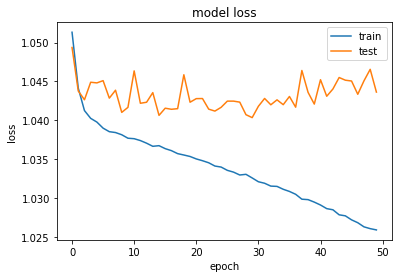

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

(481,) [0 0 0 0 2 2 0 0 0 0 0 0 0 1 0 2 2 2 0 0 2 2 2 0 0 0 0 2 2 2 2 2 0 2 2 0 2
 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 2 0 0 2 2 2 2 0 0 2 2 0 0 0 0 2 0 2 2 2
 0 2 2 0 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 2 0 2 2 0 2 2 2 2 2 2 2 0 0 0 0 0
 0 2 2 0 2 0 0 0 0 0 0 2 0 2 0 0 2 2 0 0 0 0 0 0 2 2 0 2 0 0 2 2 2 0 0 0 2
 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 2 2 0 2 2 2
 0 2 0 0 0 0 2 0 2 2 2 2 2 2 0 0 2 2 2 2 0 0 2 2 0 0 2 0 0 0 0 0 0 0 0 1 1
 2 0 0 0 0 0 0 0 2 2 0 0 0 2 2 0 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 2 2 2 0 2 2
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 2 2 2 0 0 2 0 0 0 0 0
 0 0 2 2 2 2 2 2 2 2 0 2 2 2 2 0 0 2 0 0 2 0 0 0 0 2 0 0 0 2 2 0 0 0 2 2 2
 2 2 2 0 0 0 0 0 0 2 2 2 0 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 1 0 0
 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 2 2 2
 2 0 0 0 0 2 2 0 2 0 2 0 0 0 2 2 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 2 0 2 0 2 2 2 0 2 0 0 0 2 2 2 2 2 0 2 0 0 0 0 0 2 2 0 0 0 0 0 0 0]
(481,)


C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


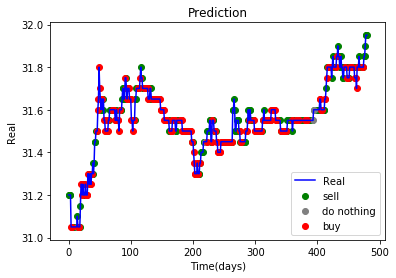

In [15]:
test_x, test_y, sc_parameter = create_dataset(path=paths[990], input_days=input_days, output_days=output_days)
test_x[np.isnan(test_x)] = 0
test_x_input = np.expand_dims(encoder.predict(test_x), axis=1)
pred = np.argmax(model.predict(test_x_input), axis=-1)
print(pred.shape, pred)

# pred = np.argmax(test_y, axis=-1)

test_sc = MinMaxScaler()
test_sc.updatePatameter(sc_parameter)
test_real = test_x[:, -1, 0]
test_real = test_sc.getInverseData(test_real)
output_action = pred
print(test_real.shape)

# Visualising the results
plot = test_real
sell = np.where(output_action==0)
do_nothing = np.where(output_action==1)
buy = np.where(output_action==2)
plt.plot(plot, color = 'blue', label = 'Real')
plt.scatter(sell, plot[sell], color = 'green', label = 'sell')
plt.scatter(do_nothing, plot[do_nothing], color = 'gray', label = 'do nothing')
plt.scatter(buy, plot[buy], color = 'red', label = 'buy')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()